/Users/victor/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


acc = 0.85 F1-score = 0.66
[[23032  1688]
 [ 3114  4727]]


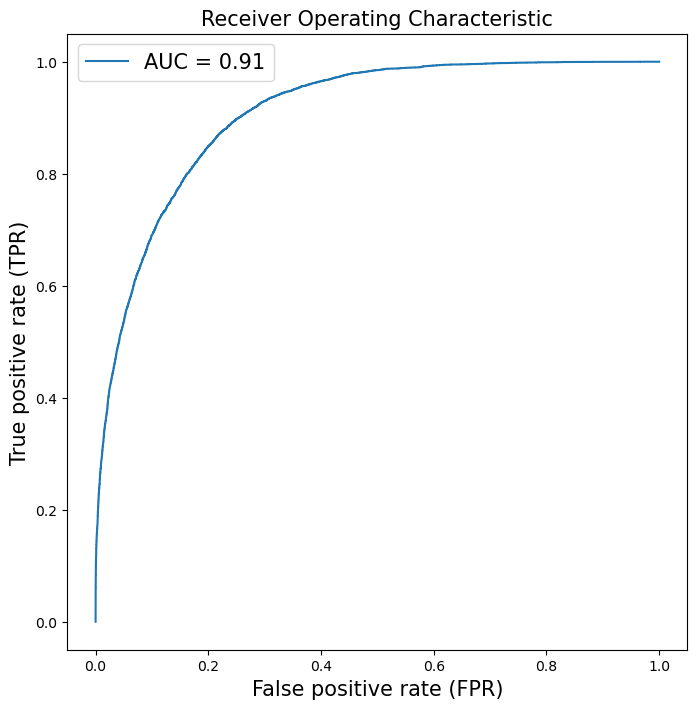

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def prepare_adult_data(delete_native_country = True):
    adult = pd.read_csv('../../data/adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                            'education-num', 'marital-status', 'occupation',
                            'relationship', 'race', 'sex', 'capital-gain',
                            'capital-loss', 'hours-per-week', 'native-country', 'salary'])


    if delete_native_country == True:
        # Избавиться от лишних признаков
        adult.drop(['native-country'], axis=1, inplace=True)
    else:
        li = adult['native-country'].value_counts()
        adult['native-country'] = adult['native-country'].apply(lambda x: x if li[x] > 100 else 'other')
        adult = pd.get_dummies(adult, columns=['native-country'])

    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']]
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

    # Разбить таблицу данных на матрицы X и Y
    X = adult[list(set(adult.columns) - set(['salary']))]
    Y = adult['salary']

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

    return X, Y

# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

def train_validate(X, Y, penalty_reg):
    model = LogisticRegression(penalty = penalty_reg)
    model.fit(X, Y)

    Y_pred = model.predict(X)

    print_logisitc_metrics(Y, Y_pred)
    print(confusion_matrix(Y, Y_pred))
    calc_and_plot_roc(Y, model.predict_proba(X)[:, 1])

def train_validate_best_l2(X, Y):
    best_f1_score = 0.0
    l2_coeff = 0
    for i in np.arange(0.01, 1.01, 0.01):
        model = LogisticRegression(penalty = 'l2', C = round(i, 2))
        model.fit(X, Y)
        f1 = f1_score(Y, model.predict(X))
        if (f1 > best_f1_score):
            best_f1_score = f1
            l2_coeff = round(i, 2)
    print(f'l2_coeff = {l2_coeff:.2f}, best F1-score = {best_f1_score:.2f}')


X, Y = prepare_adult_data(False)
train_validate(X, Y, 'l2')
